# 1 - Métodos de clustering jerárquico


En esta práctica vamos a ver cómo funcionan los algoritmos jerárquicos vistos en clase: el aglomerativo y el divisivo.

### Clustering jerárquico aglomerativo

En esta práctica estudiaremos el funcionamiento y la utilización del clústering jerárquico aglomerativo.

Para empezar, cargamos las librerías que vamos a necesitar:

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

### Ejemplo 1

Generamos nuestro dataset de juguete:

(150, 2)


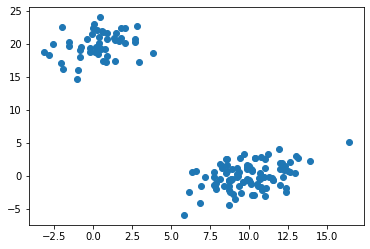

In [ ]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

Ya tenemos nuestro dataset, que como podéis comprobar es bien sencillo, para poder comprender bien el funcionamiento del clustering jerárquico.

Vamos a realizar el clustering:

In [ ]:
Z = ## Aquí tu código ##

Ya está. Fácil, ¿no os parece?

Fijaos que `scipy` nos permite elegir qué método queremos elegir entre:

-   `single`: disimilitud mínima
-   `complete`: disimilitud máxima
-   `average`: disimilitud media
-   ... y más

Y también nos permite elegir la medida de disimilitud que queremos utilizar para calcular las distancias entre clusters: `euclidean` (por defecto), `cityblock` (Manhattan), `hamming`, `cosine`, etc.

Recordad que se debe escoger la medida de disimilitud teniendo en cuenta el tipo de datos que tenemos. Por ejemplo, si tuviesemos vectores de características binarios, usaríamos la distancia `hamming`.

Vamos a medir la bondad de este clustering. Para ello, vamos a hacer uso del `Cophenetic Correlation Coefficient` (https://en.wikipedia.org/wiki/Cophenetic_correlation), disponible en la función `cophenet()` de `scipy.cluster.hierarchy`.

Esta función compara (correla) las distancias reales entre todas las muestras de nuestro dataset con aquellas que implica el clustering obtenido. Cuanto más cerca este el valor de 1, mejor preserva el clustering las distancias originales, por lo que mejor es el clusering.

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# pdist calcula las distancias entre elementos de nuestro dataset usando la 
# métrica indicada (euclideana por defecto)
c, coph_dists = cophenet(## Aquí tu código ##)
print(c)

No importa qué método o métrica elijamos, la función `linkage` utilizará ese método y métrica para calcular las distancias entre los clusters (empezando por `k=n_instancias` clusters que tendrá al principio, es decir, cada muestra del dataset es un cluster) y en cada iteración mezclará los dos clusters con la distancia más pequeña de acuerdo al método y distancia elegidos.

La salida de esta función (`Z`) es un vector de longitud `k-1` que nos dará información de las operaciones realizadas en cada paso. Es decir, las `k-1` uniones que han tenido lugar durante el clustering.

`Z[i]` nos dirá qué clusters fueron unidos en la iteración `i`:

In [ ]:
Z[0]

La salida es la siguiente:

`[idx1, idx2, distancia, número de muestras]`

En este caso podéis ver cómo el algoritmo ha decidido unir los clusters 52 y 53, que tenían una distancia de 0.04151, y esta operación dió como resultado un cluster con 2 instancias. `idx1` e `idx2` se corresponden con los índices de nuestras muestras. Recordad que nuestro dataset tiene 150 muestras.

Vamos a ver las 20 primeras operaciones:

In [ ]:
Z[:20]

Fijaos en lós índices, ¿véis algo raro? Fijaos también en la columna de número de muestras. ¿Qué esta pasando?

Lo que esta pasando es que cada vez que ocurre una unión, se crea un nuevo cluster con un nuevo índice (por eso hay más de 150, que es el número de muestras de nuestro dataset == el número de clusters iniciales).

De hecho, todos los clusters cuyo índice es mayor que 149 (`idx >= len(X)`), realmente se refieren al cluster formado en la unión `Z[idx - len(X)`.

Así, el `idx` 149 se corresponde con `X[149]`, pero el `idx=150` se corresponde con el cluster formado en el paso `Z[0]`, y así sucesivamente.

Si os fijáis en la iteración 13, se mezclan el cluster 62 con el 152. ¿Y qué es lo que hay en el cluster 152? Pues `Z[152-150]=Z[2]`, por lo tanto, lo que se unió en la iteración 3 (`Z` está indexado en 0). Es decir, el cluster 33 y 68.

Vamos a ver las coordenadas para ver si tiene sentido:

In [ ]:
idxs = [33, 68, 62]
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.scatter(X[idxs,0], X[idxs,1], c='r')  # plot interesting points in red again
plt.show()

print(X[idxs])

Fijaos que los puntos realmente están bastante cerca los unos de los otros, así que tiene sentido.

Vamos ahora a ver el dendograma:

In [ ]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Dendrograma')
plt.xlabel('índice de la muestra')
plt.ylabel('distancia')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Resumiendo el dendograma:

 -   Las lineas horizontales son uniones de clusters
 -   Las líneas verticales nos indican que clústers son parte de cada unión
 -   Las alturas de las líneas verticales nos indican la distancia que se "cubrió" al hacer la unión

 Además, el dendograma nos permite hacer cosas bastante útiles:

In [ ]:
# quedarnos con las últimas p uniones
plt.title('Hierarchical Clustering Dendrograma (truncado)')
plt.xlabel('índice de la muestra')
plt.ylabel('distancia')
dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar solo las últimas p uniones
    p=12,  # definimos p
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
)
plt.show()

Vamos ahora a seleccionar en qué punto del proceso nos quedamos:

In [ ]:
d_max = 10


fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=d_max,  # plot a horizontal cut-off line
)
plt.show()

Otra visualización que puede sernos de utilidad es `clustermap` de seaborn. Aquí tenéis más información: [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html).

Veamos cómo funciona:

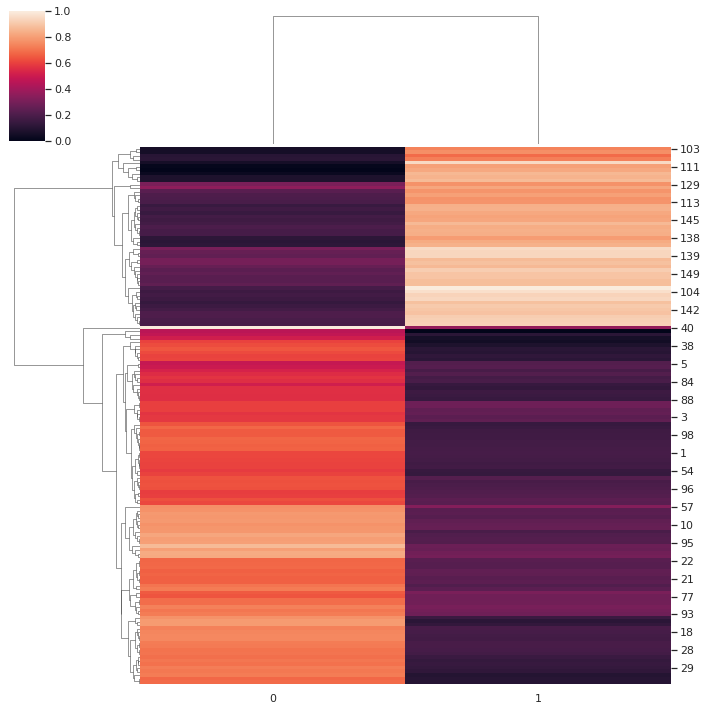

In [ ]:
import seaborn as sns
sns.set(color_codes=True)
sns.clustermap(X, standard_scale=1)

Fuente: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

### Ejemplo 2

Vamos a ver un segundo ejemplo, esta vez real.

Imaginaos que pertenecéis a la junta directiva de un centro comercial y queréis hacer un estudio de qué perfil de cliente es el más rentable para vosotros.

Para ello, vamos a hacer uso de este dataset: https://stackabuse.s3.amazonaws.com/files/hierarchical-clustering-with-python-and-scikit-learn-shopping-data.csv.

In [ ]:
!rm hier*

In [ ]:
!wget https://stackabuse.s3.amazonaws.com/files/hierarchical-clustering-with-python-and-scikit-learn-shopping-data.csv
!ls -la

In [ ]:
import pandas as pd
customer_data = pd.read_csv('hierarchical-clustering-with-python-and-scikit-learn-shopping-data.csv')
customer_data.head()

Para poder visualizarlo, vamos a quedarnos con las 2 columnas, y vamos a realizar un clustering con ellas para ver qué tipos diferentes de clientes tenemos:

In [ ]:
data = customer_data.iloc[:, 3:].values
print(data[:10])

In [ ]:
# realizamos el clustering

plt.figure(figsize=(10, 8))
plt.title("Dendograma de nuestros clientes")
## Aquí tu código ##

Fijaos que parece que encuentra 5 tipos de clientes más o menos diferenciados (cortando en 150, donde existe la mayor distancia vertical para el cluster de más a la derecha). Pero lo único que tenemos en Z es la clasificación de los clientes existentes. ¿Y si quisieramos predecir un nuevo cliente?

Necesitamos hacer uso de `AgglomerativeClustering`:

In [ ]:
from sklearn.cluster import AgglomerativeClustering

## Aquí tu código ##

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')

Veamos también la visualización con `clustermap`:

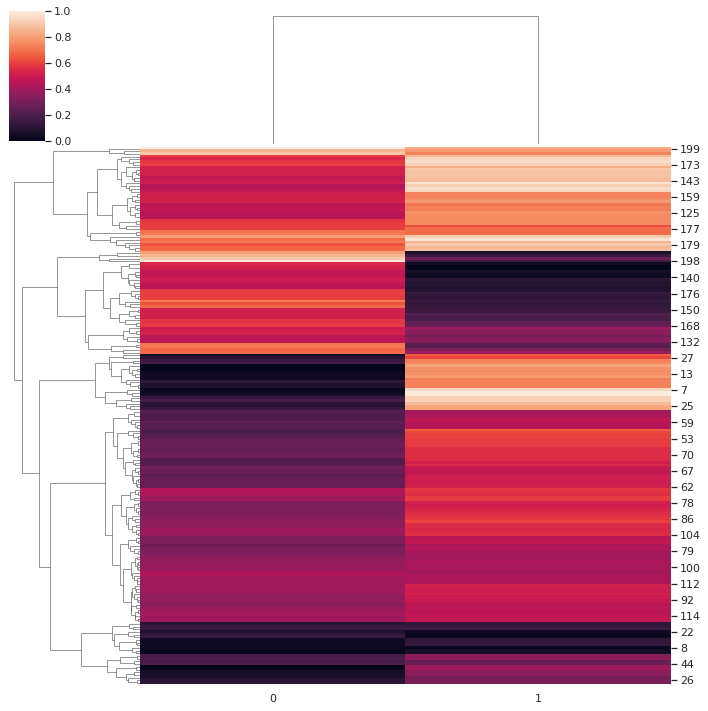

In [ ]:
sns.set(color_codes=True)
sns.clustermap(data, standard_scale=1)